In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
import nltk
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel  # If required, move this line to the appropriate place
import pyLDAvis.gensim_models as gensimvis


In [3]:
!pip install pyLDAvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:

# Function for text preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text
data = pd.read_csv('/content/train_preprocessed.csv')
# Apply preprocessing to the 'comment_text' column
data['processed_comment'] = data['comment_text'].apply(preprocess_text)

# Using CountVectorizer to convert text data to a matrix of token counts
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['processed_comment'])

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

# Reduce dimensionality using NMF (Non-Negative Matrix Factorization)
nmf = NMF(n_components=100)
X_nmf = nmf.fit_transform(X)

# Set up the parameter grid for tuning
param_grid = {
    'n_components': [ 8, 10,12],  # Number of topics (Reduced range)
    'learning_decay': [0.7, 0.9],  # Learning decay parameter (Reduced range)
    'max_iter': [10, 20]  # Maximum number of iterations (Reduced range)
    # Add more parameters and their respective values for tuning
}

# Applying GridSearchCV for hyperparameter tuning with reduced parameters
lda = LatentDirichletAllocation(random_state=42)
grid_search = GridSearchCV(lda, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_nmf)  # Fit on the reduced dimensionality data

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)




Best Parameters: {'learning_decay': 0.7, 'max_iter': 20, 'n_components': 8}
Best Score: -5736.669901836877


In [8]:
best_lda_model = grid_search.best_estimator_

# Show the top words per topic in the best LDA model
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(best_lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words_indices = topic.argsort()[-100:]
    top_words = [feature_names[i] for i in top_words_indices]
    print(top_words)

Topic 1:
['accept', 'access', 'absolutely', 'able', 'actual', 'address', 'american', 'academic', 'age', 'article', 'ask', 'apology', 'attack', 'add', 'according', 'actually', 'appears', 'administrator', 'arrest', 'allow', 'authority', 'art', 'appreciated', 'assuming', 'august', 'blocking', 'away', 'argument', 'apologize', 'addition', 'based', 'arbcom', 'asking', 'answer', 'asked', 'assume', 'band', 'artist', 'appropriate', 'award', 'admins', 'ago', 'attempt', 'big', 'automatically', 'bitch', 'available', 'author', 'attention', 'accepted', 'ban', 'album', 'appear', 'biased', 'act', 'avoid', 'argue', 'bad', 'behavior', 'allowed', 'area', 'banned', 'biography', 'best', 'asia', 'basis', 'australia', 'background', 'added', 'apparently', 'archive', 'al', 'bit', 'adding', 'agree', 'blog', 'agenda', 'belief', 'aware', 'bias', 'admin', 'america', 'battle', 'accurate', 'appreciate', 'action', 'beginning', 'anti', 'accusation', 'better', 'acceptable', 'afd', 'barnstar', 'basically', 'april', 'acc

In [ ]:
#visulization

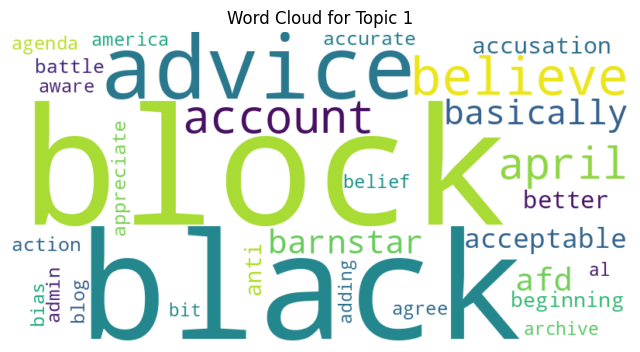

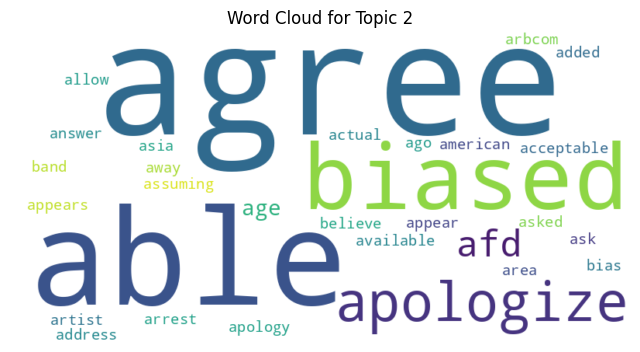

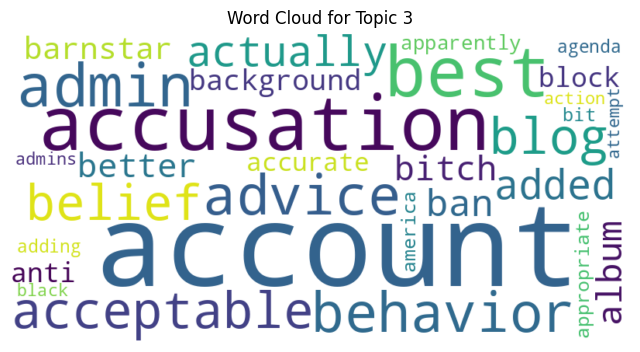

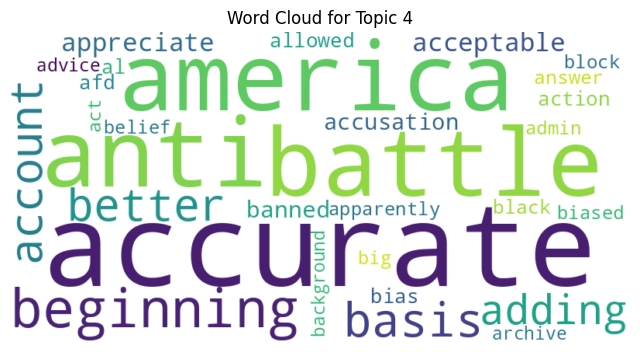

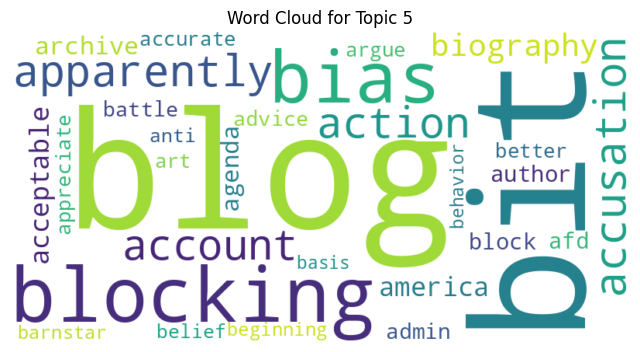

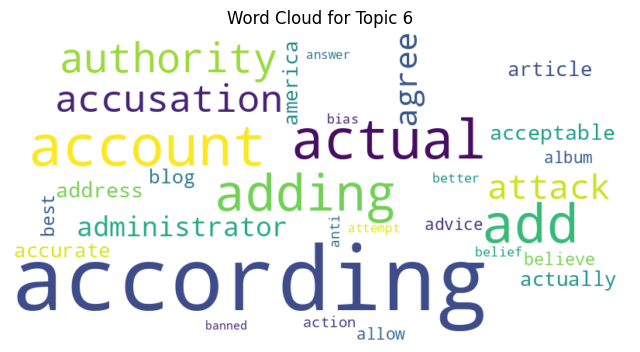

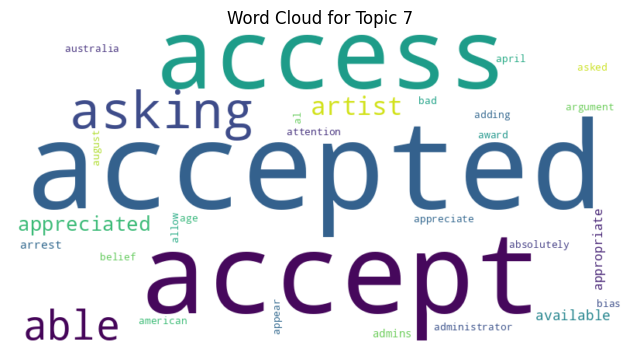

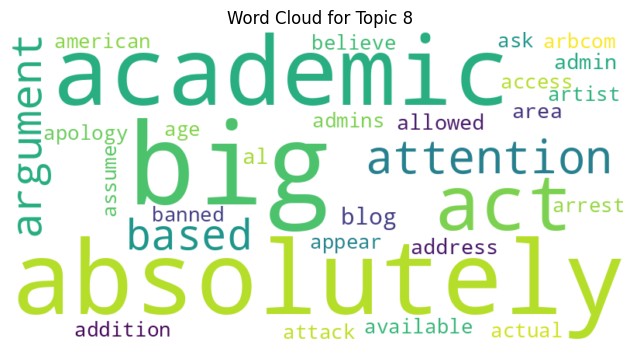

In [10]:
from wordcloud import WordCloud

# Generate word clouds for each topic
for topic_idx, topic in enumerate(best_lda_model.components_):
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[-30:]}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic {topic_idx + 1}")
    plt.show()


In [28]:
# Function for text preprocessing
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return lemmatized_tokens  # Return a list of tokens

# Apply preprocessing to the 'comment_text' column
data['processed_tokens'] = data['comment_text'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = Dictionary(data['processed_tokens'])

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in data['processed_tokens']]


In [26]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize

In [14]:
# Train the LDA model (example)
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust number of components as needed
best_lda_model = lda.fit(X)  # Fit the model to your data X

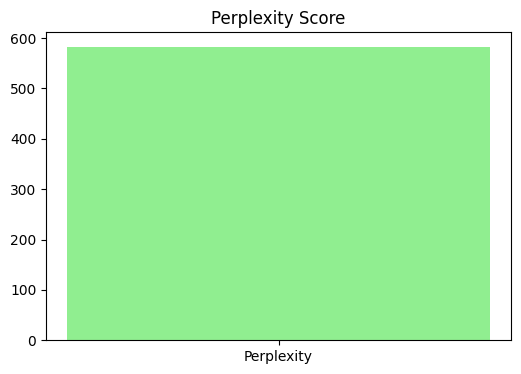

In [16]:
# Calculate perplexity score
perplexity_score = best_lda_model.perplexity(X)

# Visualize perplexity score
plt.figure(figsize=(6, 4))
plt.bar('Perplexity', perplexity_score, color='lightgreen')
plt.title('Perplexity Score')
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate pairwise cosine similarity for topic-word distributions
cosine_similarities = cosine_similarity(best_lda_model.components_)

# Calculate coherence score manually
coherence_score = cosine_similarities.sum(axis=1).mean()

print("Coherence Score:", coherence_score)


Coherence Score: 3.0097356876665704


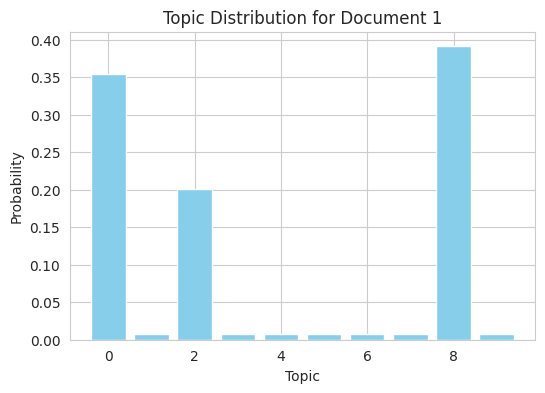

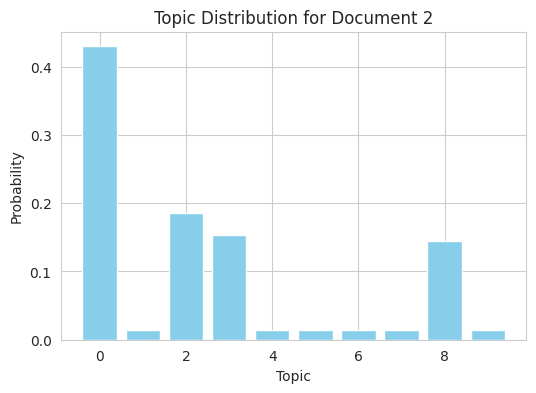

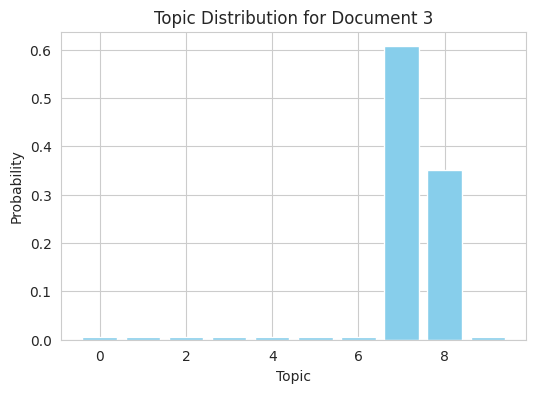

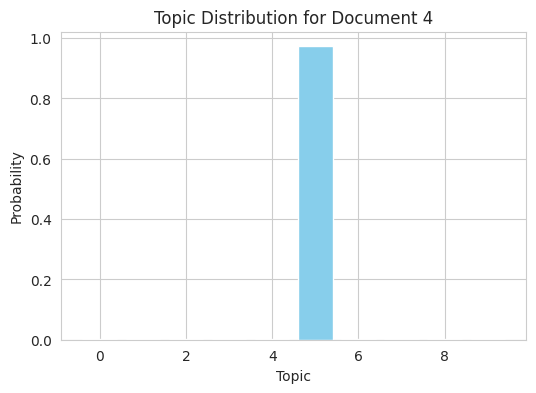

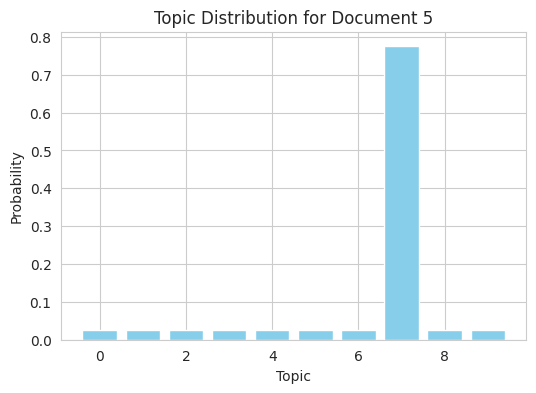

In [18]:
# Get topic distribution for documents
topic_results = best_lda_model.transform(X)

# Visualize topic distribution for a few documents (for example, first 5)
import seaborn as sns
sns.set_style('whitegrid')
for i in range(5):
    plt.figure(figsize=(6, 4))
    plt.bar(range(best_lda_model.n_components), topic_results[i], color='skyblue')
    plt.xlabel('Topic')
    plt.ylabel('Probability')
    plt.title(f'Topic Distribution for Document {i+1}')
    plt.show()


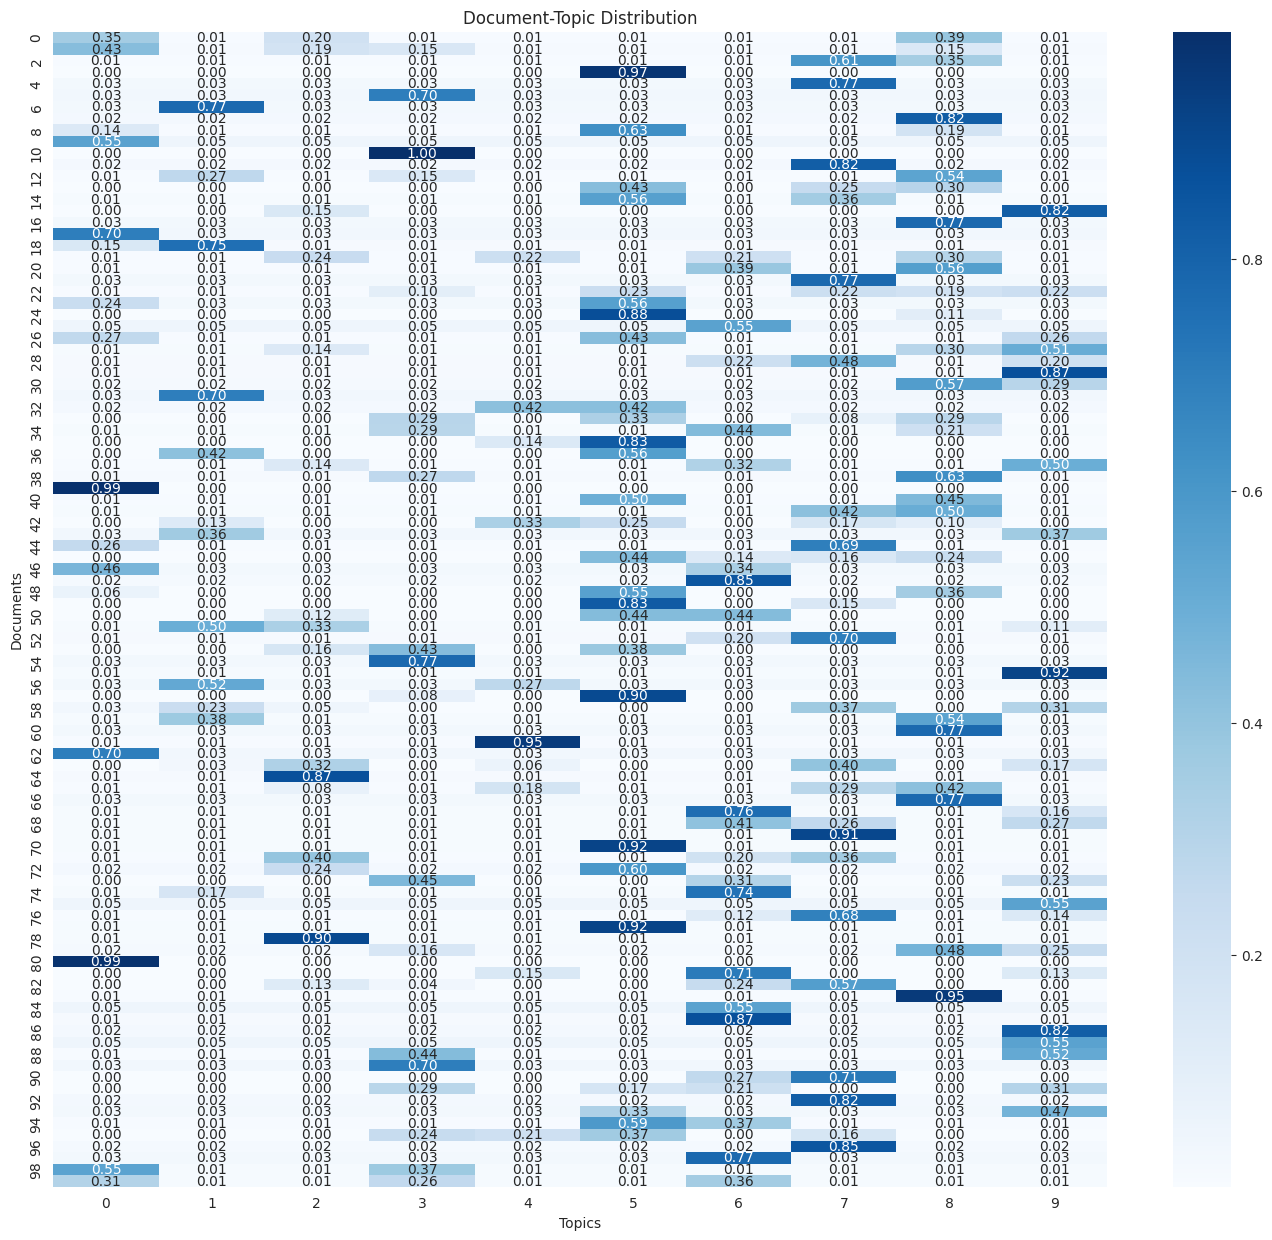

In [24]:
# Plotting a confusion-matrix-like visualization for topic distributions across documents
plt.figure(figsize=(17, 15))
sns.heatmap(topic_results[:100], cmap='Blues', annot=True, fmt='.2f')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.title('Document-Topic DistributSion')
plt.show()

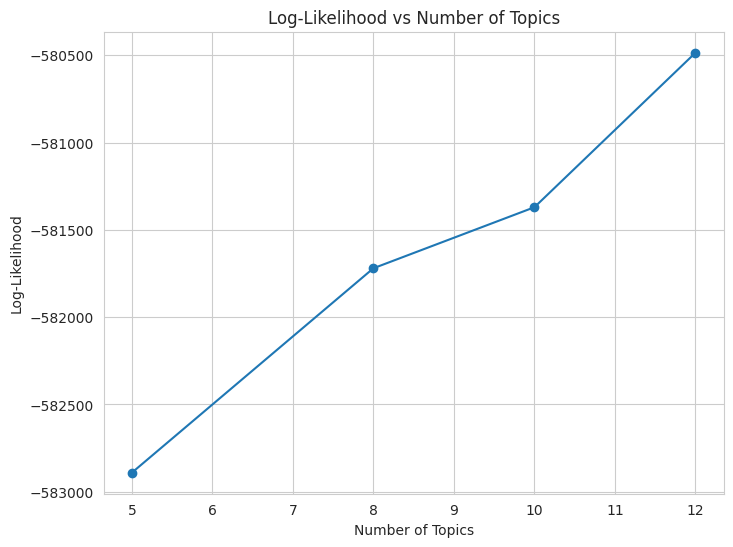

In [29]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
#loss  curve
num_topics = [5, 8, 10, 12]  # Modify this list with your desired number of topics
log_likelihoods = []

for n in num_topics:
    lda = LatentDirichletAllocation(n_components=n, random_state=42)
    lda.fit(X)  # Replace X with your dataset
    log_likelihoods.append(lda.score(X))  # Compute the log-likelihood score

# Plotting log-likelihoods against number of topics
plt.figure(figsize=(8, 6))
plt.plot(num_topics, log_likelihoods, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Number of Topics')
plt.grid(True)
plt.show()


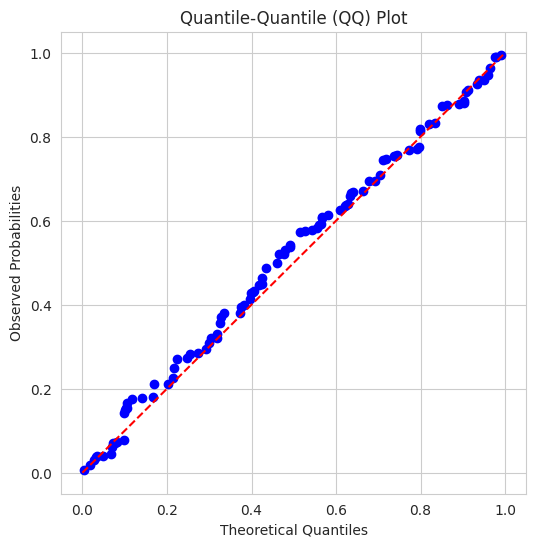

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'topic_probs' contains the probability distribution of topics for a document
# Replace 'topic_probs' with your actual topic probabilities
topic_probs = np.random.rand(100)  # Example random probabilities (replace this line)

# Generate theoretical quantiles from a uniform distribution
theoretical_quantiles = np.random.uniform(0, 1, len(topic_probs))  # Modify as needed

# Sort the observed probabilities and theoretical quantiles
sorted_probs = np.sort(topic_probs)
sorted_theoretical_quantiles = np.sort(theoretical_quantiles)

# Create QQ plot
plt.figure(figsize=(6, 6))
plt.scatter(sorted_theoretical_quantiles, sorted_probs, color='blue')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Probabilities')
plt.title('Quantile-Quantile (QQ) Plot')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for reference
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


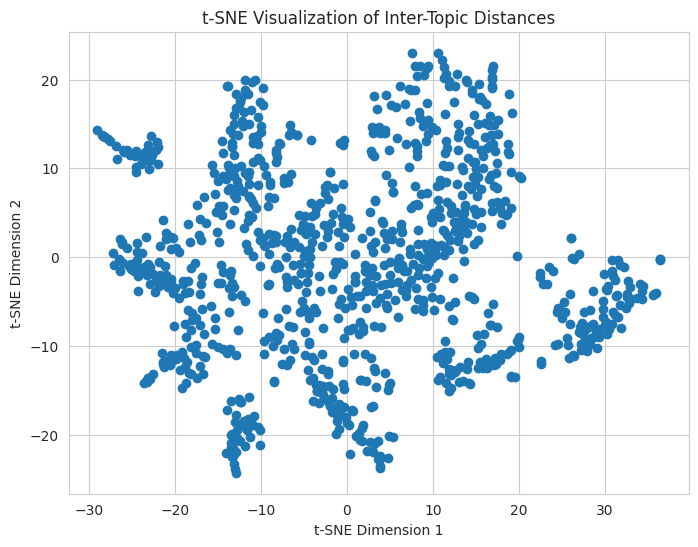

In [47]:
from sklearn.manifold import TSNE

# Get the topic-word matrix from the best LDA model
topic_word_matrix = best_lda_model.components_

# Apply t-SNE to reduce dimensions for visualization
tsne_model = TSNE(n_components=2, random_state=42, n_iter=2500, perplexity=50)
tsne_topics = tsne_model.fit_transform(topic_word_matrix.T)

# Plot t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(tsne_topics[:, 0], tsne_topics[:, 1], marker='o')
plt.title('t-SNE Visualization of Inter-Topic Distances')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
# Calculate coherence scores
coherence_model_lda = CoherenceModel(model=best_lda_model, texts=data['processed_comment'],
                                     dictionary=dictionary, coherence='c_v')
coherence_scores = coherence_model_lda.get_coherence_per_topic()

# Visualize coherence scores per topic
topics = range(1, len(coherence_scores) + 1)
plt.figure(figsize=(10, 6))
plt.bar(topics, coherence_scores, color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Coherence Score')
plt.title('Coherence Score per Topic')
plt.show()
